## imports

In [2]:
import pandas as pd
from pandas import DataFrame
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

from typing import List

## Carregando dados

In [4]:
def get_data_index(timestep=0, folder='pops3'):
    files = os.listdir(folder)

    files_data = [file for file in files if re.search(r'Data', file)]
    files_index = [file for file in files if re.search(r'Ids', file)]

    # Ordena arquivos por timestep (numero pós o "t")
    files_data = sorted(files_data, key=lambda x: int(x.split('t')[1].split()[0]))
    files_index = sorted(files_index, key=lambda x: int(x.split('t')[1].split()[0]))


    current_df = pd.read_csv(f'pops3/{files_data[timestep]}', sep='\t', header=None)
    current_df.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

    current_df_indexes = pd.read_csv(f'pops3/{files_index[timestep]}', sep='\t', header=None)
    current_df_indexes.columns = ['ancestral', 'id']

    current_df['id'] = current_df_indexes['id']

    
    return current_df, current_df_indexes


In [4]:
data, index = get_data_index(timestep=10)

In [5]:
data

,a,b,c,d,e,f,g,h,i,j,id
0,2.43102,-5.10363,4.19179,3.03037,-3.30818,-2.49360,2.69583,4.60896,-0.63564,-5.36439,1
1,-6.24984,-4.05154,3.50351,3.52534,-3.44175,-3.38966,-4.72292,-2.16082,-3.52027,-4.06767,2
2,-4.03141,-4.75464,-2.62887,-4.52095,-1.26427,-2.31962,2.79425,-3.19461,-3.05889,-3.63173,3
3,2.73332,-1.83434,-3.48935,3.57565,6.33370,1.80881,4.71284,2.91752,4.69356,4.27391,4
4,-3.50568,4.60009,4.86498,3.15577,4.15590,2.72134,-3.27626,3.75862,4.72451,-2.58930,5
...,...,...,...,...,...,...,...,...,...,...,...
1995,3.20039,-1.60146,-3.64028,-2.87016,-5.18239,4.59655,3.72156,-4.05901,-4.70278,2.74150,1996
1996,-3.13230,3.08192,-4.48173,-2.94267,4.85203,1.98730,-2.58605,-2.41194,-3.83327,-4.21952,1997
1997,1.90702,1.29469,-3.71221,-4.14376,-1.17726,-2.95181,-4.00854,2.22778,-0.86818,-4.21909,1998
1998,-2.87437,-1.54905,-1.98366,3.79311,-3.13998,-4.50066,-4.36642,3.81207,4.55173,-2.89036,1999


In [6]:
index

,ancestral,id
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
1995,0,1996
1996,0,1997
1997,0,1998
1998,0,1999


## Entendendo o problema

Possuímos 2 datasets, data e index:

- data: possui 10 colunas, onde cada linha é um indivíduo e cada coluna é uma característica genética daquele indivíduo.
- index: possui 2 colunas, a primeira coluna é o identificador do ancestral e a segunda coluna é o identificador do indivíduo.

Não temos controle sobre as populações, no sentido de que não conseguimos determinar o processo de surgimento de uma população em detrimento da outra, pois, para isso, teriamos que realizar uma análise a nível de indivíduo, o que não é possível, visto que nosso grau de granularidade máximo é a população, por isso, devemos abstrair esse processo e entender que isso virá a partir dos dados.

Vamos analizar como nossas populações se comportam no instante inicial

In [5]:
'''
Para fazer essa análise utilizaremos o TSNE, que de maneira simples, 
maximiza a similaridade entre a distribuição de probabilidade dos pares de pontos 
de dados no espaço original e os pares de pontos de dados no novo espaço (de dimensão menor).
Com isso, temos uma redução da dimensionalidade original dos dados.

Contudo, não podemos usar o resultado do TSNE para treinamento 
(o motivo envolve tanto porque não é uma transformação invertível e reproduzivel em novos dados, 
visto que é probabilística, tanto porque distorce a estrutura dos dados global 
de tal forma que enviesa as relações entre os pontos), somente para visualização. 
Ainda assim, não é desejado utilizar nenhuma técnica de redução de dimensionalidade, 
pois queremos manter o espaço gênico previamente definido.
'''


def plot_tsne(data: DataFrame, perplexity : int = 30, learning_rate: int = 200):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    df_tsne = tsne.fit_transform(data.drop(columns='id'))

    # Convertendo o resultado para um DataFrame
    df_tsne = pd.DataFrame(df_tsne, columns=['TSNE_1', 'TSNE_2'])

    # Plotando os dados transformados
    plt.figure(figsize=(10, 6))
    plt.scatter(df_tsne['TSNE_1'], df_tsne['TSNE_2'])
    plt.xlabel("TSNE 1")
    plt.ylabel("TSNE 2")
    plt.title("Visualização t-SNE de um DataFrame Genérico")
    plt.show()

In [9]:
data, index = get_data_index(timestep=0)

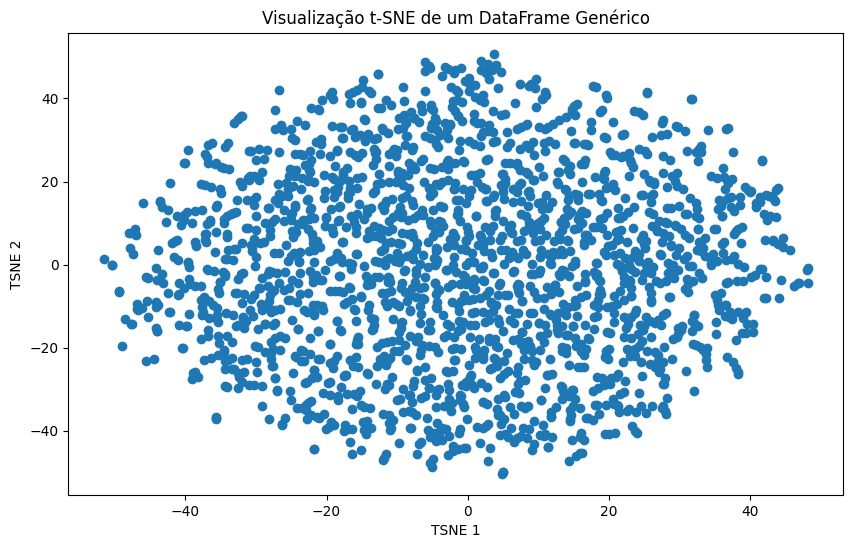

In [13]:
plot_tsne(data)

Como será que as populações se distanciam com o passar dos anos? Vamos visualizar

In [14]:
data, _ = get_data_index(timestep=100)

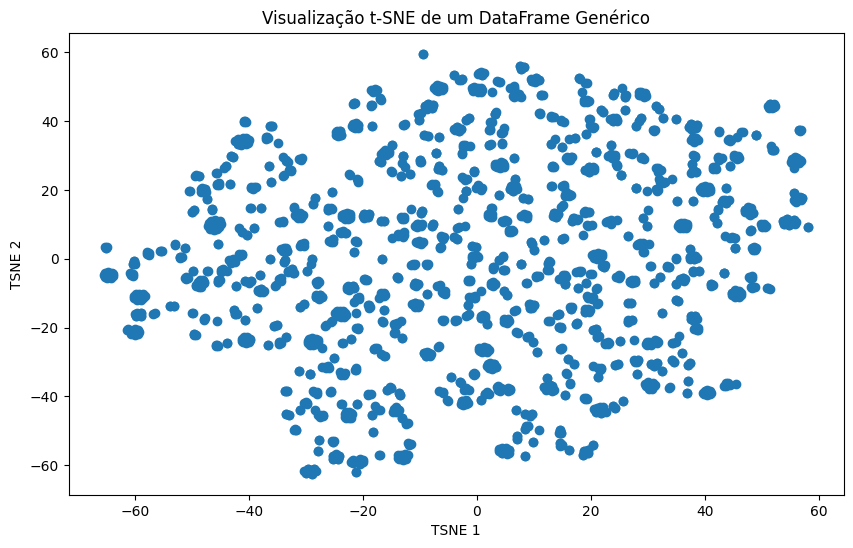

In [15]:
plot_tsne(data)

Claro que como se trata de uma redução de dimensionalidade, o resultado visto não necessariamente reproduz a realidade, mas é um bom indicativo, onde podemos ver que de fato ocorre um afastamento das populações

O principal objetivo aqui é tentar retirar a informação do número de espécies existentes, a partir das populações. Assim, o número de espécies será dado a partir do resultado da clusterização, o que nos leva a pensar em alguns pontos.

Se temos um dataset para cada espaço de tempo definido, com possíveis números diferentes de espécies em cada um desses espaços, faremos a clusterização da seguinte forma:

Para o step atual, considerando n espécies encontradas no timestep anterior, a clusterização deveria ser realizada dentro de cada espécie, repetindo o processo para cada cada espaço de tempo. 

Assim, para cada espaço de tempo, é necessário que tenhamos salvo a qual espécie (cluster) cada população pertence. Porém, podemos ter populações extintas (não é necessário fazer nada), e novas populações, derivadas de alguma população pai. Para essas novas,considerando o timestep atual, a abordagem será colocá-las no mesmo cluster rotulado à sua população pai no timestep anterior. Assim, por mais que seja uma nova população, quem vai decidir se ela forma uma nova espécie em relação à população pai ou não, será o nosso algoritmo de clusterização DBSCAN.

Outro ponto, é que se iremos propagar os clusters para cada espaço de tempo, devemos salvar sempre um esquema de mapeamento, onde teremos as populações e as respectivas espécies.
Outro ponto é que precisamos realizar a clusterização em cima dos dados completos no primeiro instante de tempo para que possamos ter um ponto de partida para a clusterização dos próximos instantes de tempo.
    

## Clusterização

Primariamente, utilizaremos como modelo o DBSCAN (com parâmetrização sugerida) para realizar a clusterização. A escolha do algoritmo e parâmetros faz sentido por alguns aspectos:

1. Não é necessário informar a quantidade de clusters (o que é um ponto positivo, pois não sabemos a quantidade de espécies)
2. A escolha de MinPoints = 1 faz todo sentido, pois não existem outliers no nosso problema, uma população que se afasta das demais não deveria ser considerada um outlier, e sim uma nova espécie (o que acontecerá).
3. A escolha de um eps permite que usemos conhecimento prévio do problema, onde um especialista pode calcular essas distâncias para dados conhecidos e inicializar o parâmetro de um bom ponto.

Por mais incomum que seja, não iremos fazer nenhuma transformação nos dados, como alguma normalização ou redução de dimensionalidade, conforme orientações do especialista do domínio.

### Gerando as primeiras espécies

In [ ]:
def plot_clusters(data: DataFrame, perplexity: int = 30, learning_rate: int = 200):
    if 'Cluster' not in data.columns:
        print('A coluna de cluster não foi encontrada')
        return
    
    clusters = data['Cluster']

    num_clusters = len(set(clusters))
    print(f"Número de Espécies: {num_clusters}")

    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42)
    df_tsne = tsne.fit_transform(data.drop(columns='id'))
    df_tsne = pd.DataFrame(df_tsne, columns=['TSNE_1', 'TSNE_2'])
    df_tsne['Cluster'] = clusters

    markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', 'x', '8']

    plt.figure(figsize=(10, 6))
    for cluster_id in sorted(df_tsne['Cluster'].unique()):
        cluster_data = df_tsne[df_tsne['Cluster'] == cluster_id]
        marker = markers[cluster_id % len(markers)]  # Cicla entre os marcadores se houver muitos clusters
        plt.scatter(cluster_data['TSNE_1'], cluster_data['TSNE_2'], label=f'Espécie {cluster_id}', marker=marker)

    plt.xlabel("TSNE 1")
    plt.ylabel("TSNE 2")
    plt.title(f"Espécies identificados pelo DBSCAN após Redução de Dimensionalidade com t-SNE")
    plt.legend(title="Espécies")
    plt.show()

In [17]:
data, _ = get_data_index(timestep=0)

In [18]:
dbscan = DBSCAN(eps=50, min_samples=1)
clusters = dbscan.fit_predict(data.drop(columns='id', errors='ignore'))

data['Cluster'] = clusters

Número de Espécies: 1


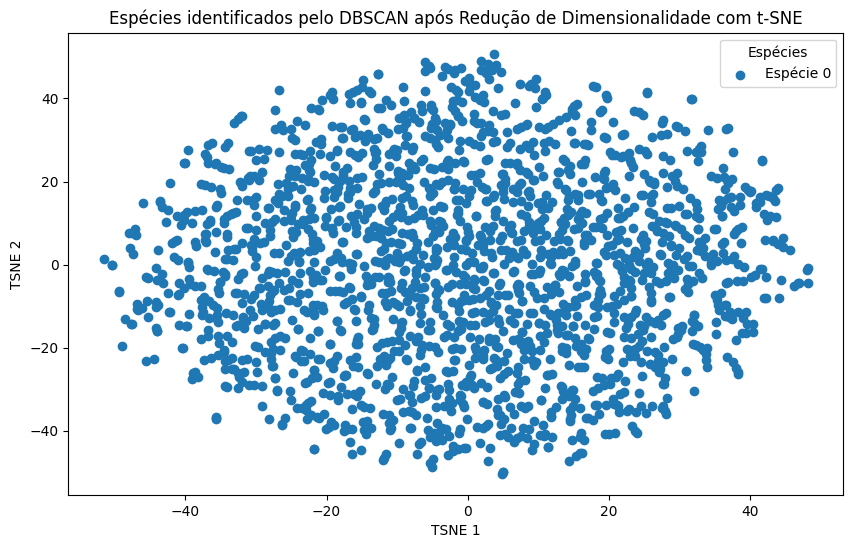

In [20]:
plot_clusters(data)

Em um momento inicial, foi visto que só possuímos uma espécie (cluster). Vamos criar uma memória e salvar essas informações ao longo do tempo. Lembrando que para cada novo cluster (espécie), reaplicaremos a clusterização somente nesse cluster

### Criando memória para salvar as espécies ao longo do tempo

A memória consistirá de um dataframe para cada instante de tempo contendo as espécies e seus respectivos clusters. Poderia ser feito em um único dataframe, mas queremos realizar uma visualização desses dados ao longo do tempo, então é mais interessante ter um dataframe para cada instante de tempo. 

In [ ]:
'''Como a parte da memória é um pouco mais sensível, vamos criar uma classe para controlar essa questão'''
import os


class SpecieMemory:
    def __init__(self, file_name : str = 'especies', data_folder : str = 'SpecieMemory'):
        self.timestep = 0
        
        self.data_folder = data_folder

        if not os.path.exists(self.data_folder): # Cria a pasta caso não exista
            os.makedirs(self.data_folder)
        
        self.file_name = file_name
        self.file_path = data_folder + '/' + file_name + str(self.timestep) + '.csv'
        
        self.memory = self.load_memory()
        
    
    def load_memory(self):
        if os.path.isfile(self.file_path):
            return pd.read_csv(self.file_path)
        else:
            df = pd.DataFrame(columns=['id', 'Cluster'])
            df.to_csv(self.file_path, index=False)
            return df


    def get_memory(self, timestep: int = None):
        if timestep is None:
            return self.memory  # Retorna a memória atual

        specific_file_path = os.path.join(self.data_folder, f"{self.file_name}{timestep}.csv")

        try:
            if os.path.isfile(specific_file_path):
                return pd.read_csv(specific_file_path)
            else:
                print(f"Timestep {timestep} não encontrado.")
                return None
        except Exception as e:
            print(f"Erro ao carregar o timestep {timestep}: {e}")
            return None
        
    
    def post_memory(self, data : DataFrame):
        """
        Envia somente o cluster e id para a pasta de memória, 
        que armazena essas labels para cada timestep
        """

        if 'Cluster' not in data.columns:
            print('A coluna de cluster não foi encontrada')
            return
        
        clusters = data['Cluster']
        index = data['id']
        
        data_memory = pd.DataFrame({'id': index, 'Cluster': clusters})
        
        self.memory = data_memory
        self.file_path = os.path.join(self.data_folder, f"{self.file_name}{self.timestep}.csv")
        self.timestep += 1
        
        data_memory.to_csv(self.file_path, index=False)
        
        
    def reset_all(self):
        self.timestep = 0

        for file in os.listdir(self.data_folder):
            if file.startswith(self.file_name) and file.endswith(".csv"):
                os.remove(os.path.join(self.data_folder, file))

        self.memory = pd.DataFrame(columns=['id', 'Cluster'])
        self.file_path = os.path.join(self.data_folder, f"{self.file_name}{self.timestep}.csv")
        self.memory.to_csv(self.file_path, index=False)
        print("Memória resetada e todos os arquivos anteriores foram removidos.")
        

In [8]:
memory = SpecieMemory()

In [26]:
print(memory.get_memory())

Empty DataFrame
Columns: [id, Cluster]
Index: []


In [27]:
memory.post_memory(data)

In [28]:
memory.get_memory()

,id,Cluster
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
1995,1996,0
1996,1997,0
1997,1998,0
1998,1999,0


Agora que temos a memória, e um instante inicial, basta que façamos o seguinte algoritmo:

1. Realizar a clusterização no instante atual (feito)
2. Salvar na memoria (feito)

3. Para cada instante de tempo, exceto o primeiro, realizar a clusterização em cada cluster (espécie)
4. Salvar o resultado na memoria e repetir o passo 3 até o último instante de tempo

In [29]:
'''Essa função serve para mapear novas populações, ou seja, 
se no instante t algum indice não estiver com uma espécie (cluster) mapeado,
iremos retornar seu índice, pois iremos o alocar na mesma espécie de seu antecessor.'''

def get_missing_ids(data : DataFrame, memoryt: DataFrame):
    return data[~data['id'].isin(memoryt['id'])]['id']

In [ ]:
'''Essa função faz de fato o mapeamento mencionado acima. 
Faremos isso da seguinte maneira: para cada id ausente,
encontraremos o ancestral e mapearemos para o mesmo cluster do ancestral, 
recebendo a memória atualizada'''

def map_to_ancestral_cluster(missing_ids: DataFrame, index: DataFrame, memoryt: DataFrame):
    mapped_ids = []

    for missing_id in missing_ids:
        # Pega o id do ancestral das novas populações
        ancestral = index[index['id'] == missing_id]['ancestral'].values
        if len(ancestral) > 0:
            print(ancestral)
            ancestral = ancestral[0]
            # Pega a label do cluster do ancestral conforme o último timestep
            cluster = memoryt[memoryt['id'] == ancestral]['Cluster'].values
            if len(cluster) > 0:
                mapped_ids.append({'id': missing_id, 'Cluster': cluster[0]})

    return pd.DataFrame(mapped_ids) if mapped_ids else pd.DataFrame(columns=['id', 'Cluster'])

In [31]:
'''Dado as novas populações e o mapeamento de espécies, 
atualizamos esse mapeamento para a memória, agora todas populações tem uma espécie associada'''

def update_memory(memory : SpecieMemory, mapped_data : DataFrame):
    memoryt = memory.get_memory()  # Carrega a memória atual
    updated_memory = pd.concat([memoryt, mapped_data], ignore_index=True)
    
    return updated_memory

In [33]:
n_data = 400 # Número de instâncias de tempo
max_cluster_id = memory.get_memory()['Cluster'].max() + 1 # Controla novos IDs de espécie

for step in range(1, n_data): # Começamos do step 1, visto que a etapa inicial já foi realizada
    data, index = get_data_index(timestep=step) # Pegamos os dados e os índices do instante atual
    memoryt = memory.get_memory(timestep=step - 1) # Pegaremos a partir do instante 0, justamente pq dado o instante atual, o mapeamento de espécies e feitoa partir do instante anterior

    missing_ids = get_missing_ids(data, memoryt) # Pegamos os índices que não possuem espécie mapeada
    mapped_data = map_to_ancestral_cluster(missing_ids, index, memoryt) # Mapeamos esses índices para suas respectivas espécies a partir da população geradora

    if not mapped_data.empty: # Se tivermos novas populações, atualizamos a memória para que as populações tenham suas espécies mapeadas
        memoryt = update_memory(memory, mapped_data)

    '''Nesse ponto já temos a memória atualizada, 
    agora precisamos fazer a clusterização para cada cluster (espécie). 
    Caso algum cluster apareça dentro de uma espécie, será necessário trabalhar com os índices,
    pois esse cluster vira uma nova espécie no mapeamento, assim,
    deveriamos atualizar da maneira correta a coluna de Cluster que será criada em data'''
    
    new_species_mapping = [] # Guarda os novos mapeamentos de espécies

    for cluster_id in memoryt['Cluster'].unique(): # Para cada espécie existente no instante de tempo t
        
        ids = list(memoryt.loc[memoryt['Cluster'] == cluster_id]['id']) # Tiramos os ids das populações pertencentes aquela espécie
        data_cluster = data.loc[data['id'].isin(ids)].copy() # Pegamos as características genéticas das populações da espécia

        if data_cluster.empty: # Caso aquela espécie seja extinta (não tenha populações) iremos passar para a próxima espécie
            continue

        dbscan = DBSCAN(eps=50, min_samples=1)
        clusters = dbscan.fit_predict(data_cluster.drop(columns='id', errors='ignore')) # Realizamos a clusterização para a espécie atual

        data_cluster['SubCluster'] = clusters 
        unique_subclusters = data_cluster['SubCluster'].unique() # Tiramos todas espécies que surgem a partir da atual

        if len(unique_subclusters) == 1: # Caso 1: Apenas um subcluster (ou seja, não surgiram novas espécies a partir da atual) - mantemos o `cluster_id` original
            data_cluster['Cluster'] = cluster_id
            new_species_mapping.append(data_cluster[['id', 'Cluster']])
            
        else:  # Caso 2: Mais de um subcluster (novas espécies a partir da espécie atual) - o primeiro mantém `cluster_id`, novos IDs para outros
            for subcluster_id in unique_subclusters:
                if subcluster_id == unique_subclusters[0]:
                    data_cluster.loc[data_cluster['SubCluster'] == subcluster_id, 'Cluster'] = cluster_id # Mantém o `cluster_id` original para o primeiro subcluster, pois é a espécie atual

                else:
                    # Atribui novo ID de espécie para subclusters adicionais
                    data_cluster.loc[data_cluster['SubCluster'] == subcluster_id, 'Cluster'] = max_cluster_id
                    max_cluster_id += 1

                new_species_mapping.append(data_cluster[data_cluster['SubCluster'] == subcluster_id][['id', 'Cluster']])

    if new_species_mapping:
        '''new_species_data é uma lista que conta dataframes (cada dataframe com uma porção diferente dos dados e seus respectivos clusters (espécies).'''
        new_species_data = pd.concat(new_species_mapping, ignore_index=True)
        memory.post_memory(new_species_data) # Atualiza a memória com as novas espécies

    print(f"Step {step} --- espécies {memory.get_memory()['Cluster'].nunique()}.")


Step 1 --- espécies 1.
Step 2 --- espécies 1.
Step 3 --- espécies 1.
Step 4 --- espécies 1.
Step 5 --- espécies 1.
Step 6 --- espécies 1.
Step 7 --- espécies 1.
Step 8 --- espécies 1.
Step 9 --- espécies 1.
Step 10 --- espécies 1.
Step 11 --- espécies 1.
Step 12 --- espécies 1.
Step 13 --- espécies 1.
Step 14 --- espécies 1.
Step 15 --- espécies 1.
Step 16 --- espécies 1.
Step 17 --- espécies 1.
Step 18 --- espécies 1.
Step 19 --- espécies 1.
Step 20 --- espécies 1.
Step 21 --- espécies 1.
Step 22 --- espécies 1.
Step 23 --- espécies 1.
Step 24 --- espécies 1.
Step 25 --- espécies 1.
Step 26 --- espécies 1.
Step 27 --- espécies 1.
Step 28 --- espécies 1.
Step 29 --- espécies 1.
Step 30 --- espécies 1.
Step 31 --- espécies 1.
Step 32 --- espécies 1.
Step 33 --- espécies 1.
Step 34 --- espécies 1.
Step 35 --- espécies 1.
Step 36 --- espécies 1.
Step 37 --- espécies 1.
Step 38 --- espécies 1.
Step 39 --- espécies 1.
Step 40 --- espécies 1.
Step 41 --- espécies 1.
Step 42 --- espécies 1.
S

Perfeito, temos o core do nosso problema, a clusterização sendo realizada ao longo do tempo, agora surgem algumas dúvidas, será que esses clusters são consistentes? Como esse número de espécies se comporta? Vamos analisar

### Análise dos clusters

Falar de métricas em aprendizado não supervisionado é algo bem complicado, e muitos especialistas das áreas na verdade nem gostam de utilizá-las, visto que a quantidade de informação que passam não é tão decisiva para tomadas de decisões quanto as métricas de aprendizado supervisionado, por exemplo. Ainda sim, para termos uma noção do agrupamento intra-cluster, e distanciamento inter-cluster, vamos plotar algumas métricas.

Vamos ver a coerência dos clusters com indíce silhueta inicialmente.

In [10]:
def get_clusters(timestep : int = 0, memory : SpecieMemory = memory):
    data, _ = get_data_index(timestep=timestep)
    memory_t = memory.get_memory(timestep=timestep)

    merged_df = pd.merge(data, memory_t, on='id', how='inner')
    
    return merged_df

#### Silhouette Score

In [ ]:
silhouettes = []

for timestep in range(n_data):
    
    try:
        data_clusters = get_clusters(timestep=timestep)
    
        X = data_clusters.drop(columns=['Cluster', 'id'], errors='ignore')
    
        labels = data_clusters['Cluster']
        
        silhouette_avg = silhouette_score(X, labels)
        
    except:
        silhouette_avg = 0
        
    silhouettes.append(silhouette_avg)

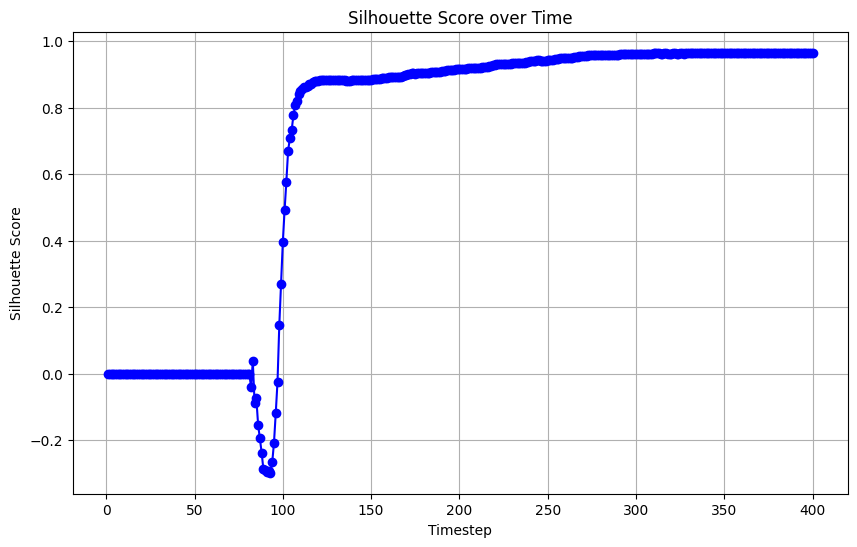

In [18]:
timesteps = list(range(1, len(silhouettes) + 1))

# Plotando a pontuação de Silhouette ao longo dos timesteps
plt.figure(figsize=(10, 6))
plt.plot(timesteps, silhouettes, marker='o', linestyle='-', color='b')
plt.xlabel('Timestep')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score over Time')
plt.grid()
plt.show()

Podemos ver que:
 
No inicio, como só tinhamos uma espécie, artificialmente colocamos silhueta igual a 0.
Tivemos uma breve caída do indice de silhouetta, possívelmente influenciado pela presença de pouquissimas espécies.
Antes do tempo 100 temos uma crescente do índice, que se estabiliza.
Após isso, temos para todos os instantes um silhouetta entre 0.85 e 0.98, o que é um bom indicativo de que os clusters são consistentes ao longo do tempo.

Esse resultado é especialmente bom, pois o indice de silhouetta é geralmente mais alto para clusters convexos do que
outros conceitos de clusters, como clusters baseados em densidade, como os
obtidos por meio do DBSCAN, e mesmo com o uso do DBSCAN tivemos uma métrica bastante alta

#### calinski_harabasz

In [ ]:
calinski_harabasz_scores = []

for timestep in range(n_data):
    try:
        print(timestep)
        data_clusters = get_clusters(timestep=timestep)

        X = data_clusters.drop(columns=['Cluster', 'id'], errors='ignore')
        labels = data_clusters['Cluster']

        ch_score = calinski_harabasz_score(X, labels)

    except:
        ch_score = 0

    calinski_harabasz_scores.append(ch_score)


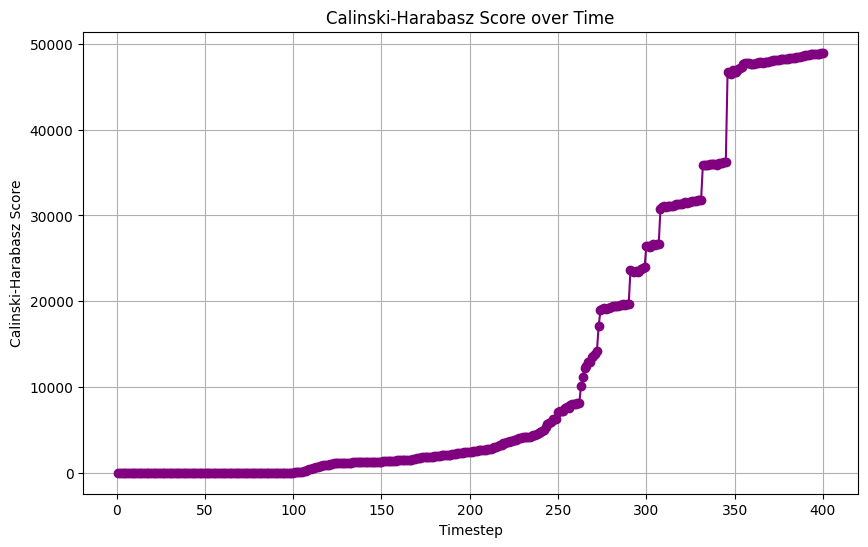

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(timesteps, calinski_harabasz_scores, marker='o', linestyle='-', color='purple')
plt.xlabel('Timestep')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score over Time')
plt.grid()
plt.show()

#### Davies-Bouldin

In [ ]:
davies_bouldin_scores = []

for timestep in range(n_data):
    try:
        print(timestep)
        data_clusters = get_clusters(timestep=timestep)

        X = data_clusters.drop(columns=['Cluster', 'id'], errors='ignore')
        labels = data_clusters['Cluster']

        db_score = davies_bouldin_score(X, labels)

    except:
        db_score = 0

    davies_bouldin_scores.append(db_score)


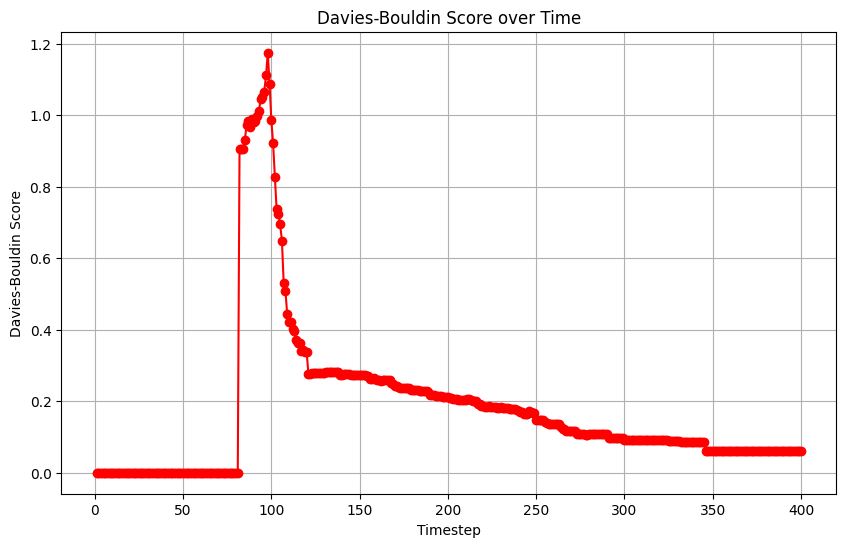

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(timesteps, davies_bouldin_scores, marker='o', linestyle='-', color='red')
plt.xlabel('Timestep')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score over Time')
plt.grid()
plt.show()


Podemos ver que temos boas métricas; posto isso, temos uma validação do agrupamento - agora vamos analisar a quantidade de espécies ao longo do tempo.

# Visualizações

In [ ]:
especies = []


for timestep in range(n_data):
    print(timestep)
    data_clusters = get_clusters(timestep=timestep)

    n_clusters = data_clusters['Cluster'].nunique()

    especies.append(n_clusters)

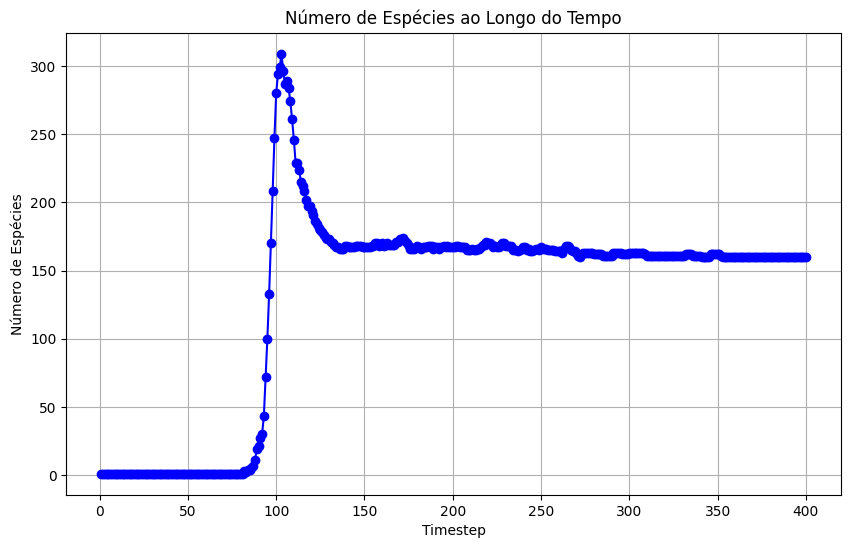

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(timesteps, especies, marker='o', linestyle='-', color='blue')
plt.xlabel('Timestep')
plt.ylabel('Número de Espécies')
plt.title('Número de Espécies ao Longo do Tempo')
plt.grid()
plt.show()

No gráfico acima, e com base na atividade desenvolvida, vemos que até o timestep 81, as populações eram de uma mesma espécie, e a partir daí começaram a se dividir cada vez mais em novas espécies, até antigir o seu pico próximo do timestep 100, ultrapassando 300 espécies (timestep 302, 309 espécies para ser exato). No entanto, logo após esse pico, começam a decair rapidamente, até ficar próximo do número 160, o qual se estabilizou ao longo do tempo. Isso pode indicar que o ambiente ficou favorável para o surgimento de novas espécies (facilitação de migração, divisão do ambiente por motivos naturais, entre outras causas), mas provavelmente acabou acontecendo alguma catástrofe natural, onde várias espécies não se adaptaram, mas muitas conseguiram prosperar. (Não é uma análise profissional biológica, somente paltada em conhecimentos gerais e na análise do gráfico, até porque sequer temos conhecimento de que tipo de população os dados tratam).

Vamos gerar um vídeo para ver os agrupamentos ao longo do tempo. Ele será anexado junto à atividade, então não é  necessário executar o colab.

In [ ]:
def animate_clusters(save_as="clusters_animation2"):
    fig, ax = plt.subplots()
    
    def update_plot(timestep):
        ax.clear()

        data_clusters = get_clusters(timestep=timestep)
        species = data_clusters['Cluster']
        X = data_clusters.drop(columns=['Cluster', 'id'], errors='ignore')
        
        tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
        data_tsne = tsne.fit_transform(X)

        ax.scatter(data_tsne[:, 0], data_tsne[:, 1], c=species, cmap='tab10')
        ax.set_title(f'Timestep {timestep} - N_Species: {species.nunique()}')
    
    ani = animation.FuncAnimation(fig, update_plot, frames=400, repeat=True)
    
    ani.save(f'{save_as}.mp4', writer='ffmpeg', fps=2) 
    plt.show()

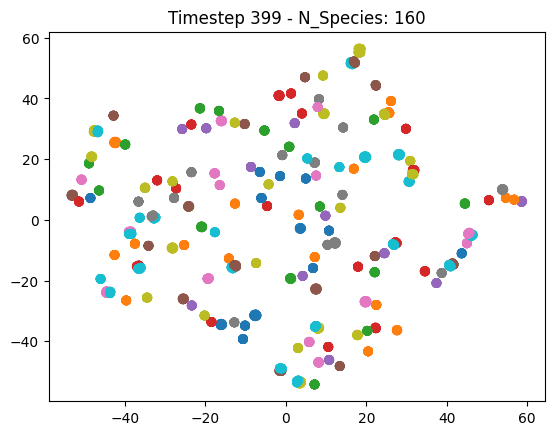

In [16]:
animate_clusters()